In [102]:
import os
import sys; sys.path.append("~/HHbbgg_ETH_devel/Training/python") # to load packages
import training_utils as utils
import numpy as np
reload(utils)
import preprocessing_utils as preprocessing
reload(preprocessing)
import plotting_utils as plotting
reload(plotting)
import optimization_utils as optimization
reload(optimization)
import postprocessing_utils as postprocessing
reload(postprocessing)
import pandas as pd
import root_pandas as rpd
import ROOT
from ROOT import TChain, TTree,TCanvas,TH1F,TList,TFile,TH2F,TPaveLabel,TPaveText,TLorentzVector
import gen_utils as gen_utils

In [103]:
ntuples = 'deepCSV_01_10_2018'
# "%" sign allows to interpret the rest as a system command
%env data=$utils.IO.ldata$ntuples
files = ! ls $data | sort -t_ -k 3 -n
signal = [s for s in files if "_node_" in s or "_nodes" in s ]

env: data=/shome/nchernya/HHbbgg_ETH_devel/root_files/deepCSV_01_10_2018


In [202]:
print signal
signalSM='output_GluGluToHHTo2B2G_node_SM_13TeV-madgraph.root'
treepath='tagsDumper/trees/'
path='/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/root_files/%s/'%ntuples

['output_GluGluToHHTo2B2G_node_SM_13TeV-madgraph.root', 'output_GluGluToHHTo2B2G_reweighted_nodes_13TeV-madgraph.root', 'output_GluGluToHHTo2B2G_SM_plus_reweighted_nodes_13TeV-madgraph.root']


In [30]:
#For properly done nodes like in 2017
#signal_df = []
#for i,sig in enumerate(signal):
#    treename = signal[i][signal[i].find('output_')+7:signal[i].find('.root')].replace('-','_')+'_13TeV_DoubleHTag_0'
#    df = rpd.read_root(path+signal[i],treepath+treename)
#    signal_df.append(df)

In [5]:
all_signal = pd.concat([signal_df[i] for i in range(0,len(signal_df))],ignore_index=True)
gen_all_signal = pd.concat([gensignal_df[i] for i in range(0,len(gensignal_df))],ignore_index=True)
print all_signal.shape
print gen_all_signal.shape
rpd.to_root(all_signal,path+'output_GluGluToHHTo2B2G_SM_plus_nodes_13TeV-madgraph.root','nodesCombined','w')
rpd.to_root(gen_all_signal,path+'output_GluGluToHHTo2B2G_SM_plus_nodes_13TeV-madgraph.root','GenNodesCombined','a')

### Reweighted 2016 nodes 

In [219]:
path='/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/root_files/deepCSV_01_10_2018/'
file = 'output_GluGluToHHTo2B2G_reweighted_nodes_13TeV-madgraph.root'
fileSM='output_GluGluToHHTo2B2G_node_SM_13TeV-madgraph.root'

In [220]:
signal_df = []
gensignal_df = []
gensignal_df_full = []
for sig in ['SM',3,4,5,8,10]:
    if sig=='SM' :
        treename='tagsDumper/trees/GluGluToHHTo2B2G_node_SM_13TeV_madgraph_13TeV_DoubleHTag_0'
        df = rpd.read_root(path+fileSM,treename)
        gentreename='genDiphotonDumper/trees/GluGluToHHTo2B2G_node_SM_13TeV_madgraph_13TeV_DoubleHTag_0'
        gendf = rpd.read_root(path+fileSM,gentreename)
        gentreename2='genDiphotonDumper/trees/GluGluToHHTo2B2G_node_SM_13TeV_madgraph_13TeV_NoTag_0'
        gendf2 = rpd.read_root(path+fileSM,gentreename2)
        gendf2 = pd.concat([gendf,gendf2],ignore_index=True)

    else :
        treename = 'GluGluToHHTo2B2G_reweighted_node_%d'%sig
        df = rpd.read_root(path+file,treename)
        df['weight'] = df['weight']/11.75
        
        gentreename = 'GluGluToHHTo2B2G_reweighted_node_%d_GenTagged'%sig
        gendf = rpd.read_root(path+file,gentreename)
        gendf['weight'] = gendf['weight']/11.75
        
        gentreename2 = 'GluGluToHHTo2B2G_reweighted_node_%d_Gen'%sig
        gendf2 = rpd.read_root(path+file,gentreename2)
        gendf2['weight'] = gendf2['weight']/11.75

    for frame in [gendf,gendf2]:
        for part in "leadPho","subleadPho","leadJet","subleadJet":
            gen_utils.calc_p4extra(frame,part) #calculating pt, eta, phi, m for each 
            gen_utils.calc_sump4(frame,"hgg","leadPho","subleadPho") #calculating pt, eta, phi, m for sum of 2 photons
            gen_utils.calc_sump4(frame,"hbb","leadJet","subleadJet") #calculating pt, eta, phi, m for sum of 2 b jets
            gen_utils.calc_sump4(frame,"hh","hbb","hgg") #calculating pt, eta, phi, m for sum of 2 Higgs"
    signal_df.append(df)
    gensignal_df.append(gendf)
    gensignal_df_full.append(gendf2)

In [221]:
reco_gen_signal_df=[]
for i in range(0,len(signal_df)):
    signal_df[i].set_index(['lumi','event','weight'])
    gensignal_df[i].set_index(['lumi','event','weight'])
    reco_gen_signal_df.append(signal_df[i].merge(gensignal_df[i][['lumi','event','weight','hh_m']]))

all_signal = pd.concat([signal_df[i] for i in range(0,len(signal_df))],ignore_index=True)
reco_gen = pd.concat([reco_gen_signal_df[i] for i in range(0,len(reco_gen_signal_df))],ignore_index=True)
gen_all_signal_full = pd.concat([gensignal_df_full[i] for i in range(0,len(gensignal_df_full))],ignore_index=True)
rpd.to_root(reco_gen,path+'output_GluGluToHHTo2B2G_SM_plus_reweighted_nodes_13TeV-madgraph.root','nodesCombined','w')
rpd.to_root(gen_all_signal_full,path+'output_GluGluToHHTo2B2G_SM_plus_reweighted_nodes_13TeV-madgraph.root','GenNodesCombined','a')

In [214]:
print sum([df.shape[0] for df in gensignal_df])
print sum([df.shape[0] for df in signal_df])
print sum([df.shape[0] for df in reco_gen_signal_df])
for df in signal_df:
    print df.shape
for df in gensignal_df:
    print df.shape
for df in reco_gen_signal_df:
    print df.shape

1050234
1060251
1068190
(17526, 81)
(208545, 81)
(208545, 81)
(208545, 81)
(208545, 81)
(208545, 81)
(17379, 69)
(206571, 68)
(206571, 68)
(206571, 68)
(206571, 68)
(206571, 68)
(17379, 82)
(206577, 82)
(206577, 82)
(206577, 82)
(224503, 82)
(206577, 82)


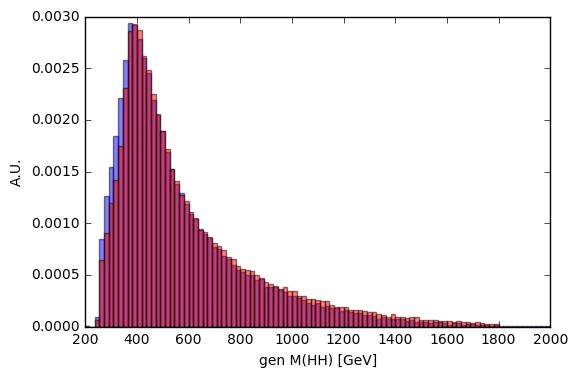

In [215]:
import matplotlib.pyplot as plt

plt.clf()

n, bins, patches = plt.hist(reco_gen['MX'], np.linspace(200,2000,100), facecolor='b',weights=reco_gen['weight'], alpha=0.5,normed=True,label='2016')
n, bins, patches = plt.hist(reco_gen['hh_m'], bins=bins, facecolor='r',weights=reco_gen['weight'], alpha=0.5,normed=True,label='2016')

plt.xlabel('gen M(HH) [GeV]')
plt.ylabel('A.U.')
plt.show()


### 2017 nodes 

In [131]:
ntuples = 'ntuples_2017_20181112'
path='/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/root_files/%s/'%ntuples
# "%" sign allows to interpret the rest as a system command
%env data=$utils.IO.ldata$ntuples
files = ! ls $data | sort -t_ -k 3 -n
signal = [s for s in files if "_node_" in s ]
treepath='tagsDumper/trees/'

env: data=/shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_2017_20181112


In [132]:
signal_df = []
for i,sig in enumerate(signal):
    if '12' in sig : continue
    print signal[i]
    treename = signal[i][signal[i].find('output_')+7:signal[i].find('.root')].replace('-','_')+'_13TeV_DoubleHTag_0'
    df = rpd.read_root(path+signal[i],treepath+treename)
    signal_df.append(df)
 #   print df.shape

output_GluGluToHHTo2B2G_node_2_13TeV-madgraph_correctedcfg.root
output_GluGluToHHTo2B2G_node_3_13TeV-madgraph_correctedcfg.root
output_GluGluToHHTo2B2G_node_4_13TeV-madgraph_correctedcfg.root
output_GluGluToHHTo2B2G_node_7_13TeV-madgraph_correctedcfg.root
output_GluGluToHHTo2B2G_node_9_13TeV-madgraph_correctedcfg.root
output_GluGluToHHTo2B2G_node_SM_13TeV-madgraph.root


In [133]:
gentreepath='genDiphotonDumper/trees/'
gensignal_df = []
gensignal_df_full = []
for i,sig in enumerate(signal):
    if '12' in sig : continue
    treename = signal[i][signal[i].find('output_')+7:signal[i].find('.root')].replace('-','_')+'_13TeV_'
    df = rpd.read_root(path+signal[i],gentreepath+treename+'DoubleHTag_0')
    for part in "leadPho","subleadPho","leadJet","subleadJet":
        gen_utils.calc_p4extra(df,part) #calculating pt, eta, phi, m for each 
        gen_utils.calc_sump4(df,"hgg","leadPho","subleadPho") #calculating pt, eta, phi, m for sum of 2 photons
        gen_utils.calc_sump4(df,"hbb","leadJet","subleadJet") #calculating pt, eta, phi, m for sum of 2 b jets
        gen_utils.calc_sump4(df,"hh","hbb","hgg") #calculating pt, eta, phi, m for sum of 2 Higgs
    gensignal_df.append(df)
   # print df.shape
    gensignal_df_full.append(df)
    gendf = rpd.read_root(path+signal[i],gentreepath+treename+'NoTag_0')
    for part in "leadPho","subleadPho","leadJet","subleadJet":
        gen_utils.calc_p4extra(gendf,part) #calculating pt, eta, phi, m for each 
        gen_utils.calc_sump4(gendf,"hgg","leadPho","subleadPho") #calculating pt, eta, phi, m for sum of 2 photons
        gen_utils.calc_sump4(gendf,"hbb","leadJet","subleadJet") #calculating pt, eta, phi, m for sum of 2 b jets
        gen_utils.calc_sump4(gendf,"hh","hbb","hgg") #calculating pt, eta, phi, m for sum of 2 Higgs
    gensignal_df_full.append(gendf)

In [134]:
reco_gen_signal_df=[]
for i in range(0,len(signal_df)):
    signal_df[i].set_index(['lumi','event'])
    gensignal_df[i].set_index(['lumi','event'])
    reco_gen_signal_df.append(signal_df[i].merge(gensignal_df[i][['lumi','event','hh_m']], how='outer').dropna(axis='index'))
all_signal = pd.concat([signal_df[i] for i in range(0,len(signal_df))],ignore_index=True)
reco_gen = pd.concat([reco_gen_signal_df[i] for i in range(0,len(reco_gen_signal_df))],ignore_index=True)
gen_all_signal_full = pd.concat([gensignal_df_full[i] for i in range(0,len(gensignal_df_full))],ignore_index=True)
rpd.to_root(reco_gen,path+'output_GluGluToHHTo2B2G_SM_plus_nodes_13TeV-madgraph.root','nodesCombined','w')
rpd.to_root(gen_all_signal_full,path+'output_GluGluToHHTo2B2G_SM_plus_nodes_13TeV-madgraph.root','GenNodesCombined','a')

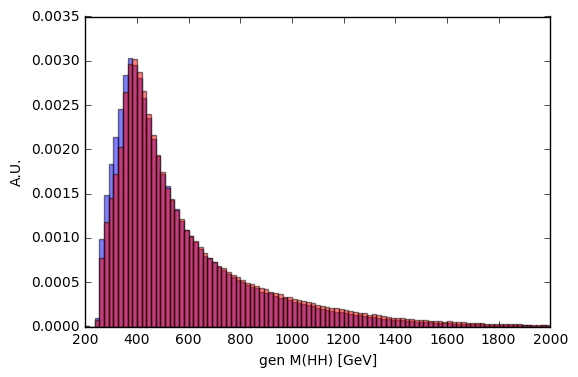

In [148]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(reco_gen['MX'], np.linspace(200,2000,100), facecolor='b',weights=reco_gen['weight'], alpha=0.5,normed=True,label='2016')
n, bins, patches = plt.hist(reco_gen['hh_m'], bins=bins, facecolor='r',weights=reco_gen['weight'], alpha=0.5,normed=True,label='2016')

plt.xlabel('gen M(HH) [GeV]')
plt.ylabel('A.U.')
plt.show()


### Reweight 2017(with more stat) to match 2016
##### But concerving overall integral!

TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: c


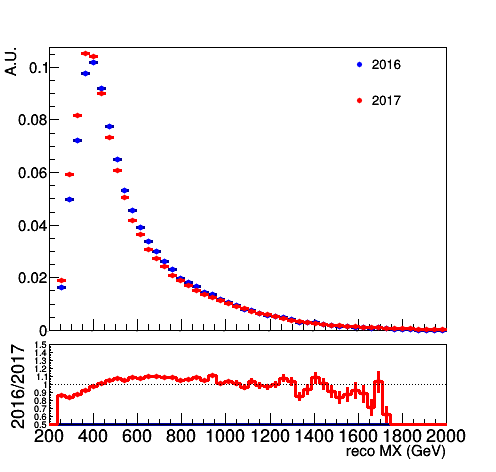

Info in <TCanvas::Print>: pdf file /mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/Training/plots/reweighted_nodes/2016_from_hists/reweight2017_to_2016_12_11.pdf has been created


In [46]:
path_2016='/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/root_files/deepCSV_01_10_2018/'
path_2017='/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_2017_20181112/'
plot_dir = '/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/Training/plots/reweighted_nodes/2016_from_hists/'
date = '12_11'
out = TFile(path_2017+'Node_reweighting_hist.root','recreate')


sum=0.
c = TCanvas("c","c",500,500)
c.SetBottomMargin(0.3)
name='nodesCombined'
infile2016 = TFile(path_2016+'output_GluGluToHHTo2B2G_SM_plus_reweighted_nodes_13TeV-madgraph.root')
infile2017 = TFile(path_2017+'output_GluGluToHHTo2B2G_SM_plus_nodes_13TeV-madgraph.root')
hists_list=[]
hists_list_2017=[]


tree_2017 = infile2017.Get(name)
hist_2017 = TH1F("hist_2017","hist_2017",50,200,2000)
hist_2017.SetLineColor(2)
hist_2017.SetMarkerColor(2)
tree_2017.Draw("MX>>hist_2017","weight")
    
tree = infile2016.Get(name)
hist = TH1F("hist_2016","hist_2016",50,200,2000)
hist.SetTitle('')
hist.GetXaxis().SetTitle('reco MX (GeV)')
hist.GetYaxis().SetTitle('A.U.')
hist.GetXaxis().SetLabelSize(0)
hist.GetXaxis().SetTitleOffset(0.91)
hist.GetYaxis().SetTitleOffset(1.4)

ROOT.gStyle.SetOptTitle(1)
ROOT.gStyle.SetOptStat(0)
tree.Draw("MX>>hist_2016","weight")

hist.Scale(1./hist.Integral())
hist_2017.Scale(1./hist_2017.Integral())
    
hist.Draw("APsame")
hists_list.append(hist)
hist_2017.Draw("same")
hists_list_2017.append(hist_2017)


leg = ROOT.TLegend(0.7,0.75,0.9,0.9)
leg.AddEntry(hist,"2016" ,"P")
leg.AddEntry(hist_2017,"2017" ,"P")
leg.SetFillStyle(-1)
leg.SetBorderSize(0)
leg.SetTextFont(42)
leg.SetTextSize(0.03)
leg.Draw()



hist_ratio = hist.Clone("ratio")
hist_ratio.Divide(hist_2017)
hist_ratio.SetLineColor(2)
hist_ratio.SetMarkerColor(2)
 
    
    
pad2 = ROOT.TPad("pad2", "pad2", 0., 0., 1., 1.)
pad2.SetTopMargin(0.73)
pad2.SetFillColor(0)
pad2.SetFillStyle(0)
pad2.Draw()
pad2.cd()
frame2 = ROOT.TH1F("frame2","",1,200,2000)
frame2.SetMinimum(0.5)
frame2.SetMaximum(1.5)
frame2.GetYaxis().SetLabelSize(0.02)
frame2.GetXaxis().SetLabelSize(0.04)
frame2.GetYaxis().SetTitleSize(0.04)
frame2.GetXaxis().SetTitle('reco MX (GeV)')
frame2.SetStats(0)
frame2.GetYaxis().SetTitle("2016/2017")
frame2.Draw()
hist_ratio.Draw("HISTsameE")

line = ROOT.TLine(200,1,2000,1)
line.SetLineStyle(3)
line.Draw("same")


out.cd()

hist_ratio.Write()
out.Close()    

c.Draw()
c.SaveAs(plot_dir+'reweight2017_to_2016_'+date+'.pdf')



TCanvas::Constructor:0: RuntimeWarning: Deleting canvas with same name: c


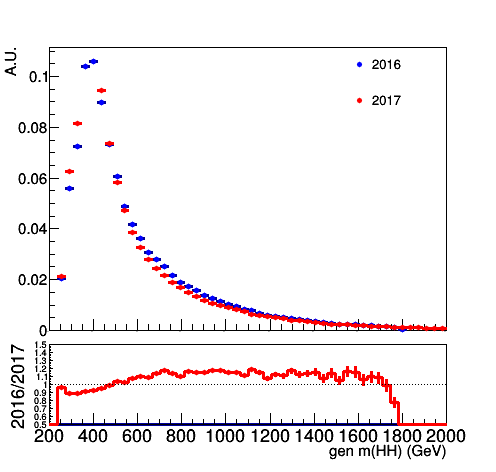

Info in <TCanvas::Print>: pdf file /mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/Training/plots/reweighted_nodes/2016_from_hists/GenMhhreweight2017_to_2016_12_11.pdf has been created


In [53]:
path_2016='/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/root_files/deepCSV_01_10_2018/'
path_2017='/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_2017data_20181023/'
path_2017='/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/root_files/ntuples_2017_20181112/'
plot_dir = '/mnt/t3nfs01/data01/shome/nchernya/HHbbgg_ETH_devel/Training/plots/reweighted_nodes/2016_from_hists/'
date = '12_11'
out = TFile(path_2017+'GenNode_reweighting_hist.root','recreate')


sum=0.
c = TCanvas("c","c",500,500)
c.SetBottomMargin(0.3)
name='GenNodesCombined'
infile2016 = TFile(path_2016+'output_GluGluToHHTo2B2G_SM_plus_reweighted_nodes_13TeV-madgraph.root')
infile2017 = TFile(path_2017+'output_GluGluToHHTo2B2G_SM_plus_nodes_13TeV-madgraph.root')
hists_list=[]
hists_list_2017=[]


tree_2017 = infile2017.Get(name)
hist_2017 = TH1F("hist_2017","hist_2017",50,200,2000)
hist_2017.SetLineColor(2)
hist_2017.SetMarkerColor(2)
tree_2017.Draw("hh_m>>hist_2017","weight")
    
tree = infile2016.Get(name)
hist = TH1F("hist_2016","hist_2016",50,200,2000)
hist.SetTitle('')
hist.GetXaxis().SetTitle('gen m(HH) (GeV)')
hist.GetYaxis().SetTitle('A.U.')
hist.GetXaxis().SetLabelSize(0)
hist.GetXaxis().SetTitleOffset(0.91)
hist.GetYaxis().SetTitleOffset(1.4)

ROOT.gStyle.SetOptTitle(1)
ROOT.gStyle.SetOptStat(0)
tree.Draw("hh_m>>hist_2016","weight")

hist.Scale(1./hist.Integral())
hist_2017.Scale(1./hist_2017.Integral())
    
hist.Draw("APsame")
hists_list.append(hist)
hist_2017.Draw("same")
hists_list_2017.append(hist_2017)


leg = ROOT.TLegend(0.7,0.75,0.9,0.9)
leg.AddEntry(hist,"2016" ,"P")
leg.AddEntry(hist_2017,"2017" ,"P")
leg.SetFillStyle(-1)
leg.SetBorderSize(0)
leg.SetTextFont(42)
leg.SetTextSize(0.03)
leg.Draw()



hist_ratio = hist.Clone("ratio")
hist_ratio.Divide(hist_2017)
hist_ratio.SetLineColor(2)
hist_ratio.SetMarkerColor(2)
 
    
    
pad2 = ROOT.TPad("pad2", "pad2", 0., 0., 1., 1.)
pad2.SetTopMargin(0.73)
pad2.SetFillColor(0)
pad2.SetFillStyle(0)
pad2.Draw()
pad2.cd()
frame2 = ROOT.TH1F("frame2","",1,200,2000)
frame2.SetMinimum(0.5)
frame2.SetMaximum(1.5)
frame2.GetYaxis().SetLabelSize(0.02)
frame2.GetXaxis().SetLabelSize(0.04)
frame2.GetYaxis().SetTitleSize(0.04)
frame2.GetXaxis().SetTitle('gen m(HH) (GeV)')
frame2.SetStats(0)
frame2.GetYaxis().SetTitle("2016/2017")
frame2.Draw()
hist_ratio.Draw("HISTsameE")

line = ROOT.TLine(200,1,2000,1)
line.SetLineStyle(3)
line.Draw("same")


out.cd()

hist_ratio.Write()
out.Close()    

c.Draw()
c.SaveAs(plot_dir+'GenMhhreweight2017_to_2016_'+date+'.pdf')

